


<center><h1> Training neural network for image Segmentation using Fast.ai and Transfer Learning</h1></center>


<center><h3> We will use a pretrained resnet model </h3></center>


In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as immg
import gc
import numpy as np
from scipy import signal
from scipy import misc
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Dataset/drone_small.zip' -d '/content/drone_data'

In [4]:
fnames_mask = get_files('/content/drone_data/label_small')
fnames = get_files('/content/drone_data/train_small')

In [5]:
path_s = Path('/content/drone_data')

In [6]:
path_s.ls()

[PosixPath('/content/drone_data/train_small'),
 PosixPath('/content/drone_data/label_small')]

In [ ]:
os.mkdir('/content/drone_data/drone_mask/')

In [ ]:
os.mkdir('/content/drone_data/drone_train/')

In [ ]:
def image_resize_lb(f,index):   # My custom function to process image to jpg and resize to
    name = str(f).split('/')[-1]
    img = PIL.Image.open(f)
    img = img.resize((600,400))
    loc = '/content/drone_data/drone_mask/'+str(f.stem)+'.png'
    img.save(loc , quality = 100)

In [ ]:
parallel(image_resize_lb,fnames_mask,max_workers=20)

In [ ]:
def image_resize_tr(f,index):   # My custom function to process image to jpg and resize to
    name = str(f).split('/')[-1]
    img = PIL.Image.open(f)
    img = img.resize((600,400),resample=PIL.Image.BILINEAR).convert('RGB')
    loc = '/content/drone_data/drone_train/'+str(f.stem)+'.png'
    img.save(loc ,quality = 100)

In [ ]:
parallel(image_resize_tr,fnames,max_workers=20)

# Data

In [9]:
fnames = get_image_files(path_s/'train_small')
fnamesMask = get_image_files(path_s/'label_small')

In [10]:
immg.imread(fnames[0]).shape

(400, 600, 3)

In [12]:
path_lbl = path_s/'label_small'
path_img = path_s/'train_small'
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'       # Function to get masks for a image
codes = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20,21,22,23,24,25])

In [ ]:
#codes = np.array(['tree','gras','other vegetation','dirt','gravel','rocks','water','paved area',
 #        'pool','person','dog','car','bicycle','roof','wall','fence','fence-pole','window','door','obstacle'])

In [ ]:
fnames[30],get_y_fn(fnames[30])

(PosixPath('/content/drone_data/train_small/590.jpg'),
 PosixPath('/content/drone_data/label_small/590.jpg'))

In [13]:
sns.set_style('darkgrid')

## Function to show chest X_ray with Mask

In [14]:
def drone_mask(f):  # f = file_name
  img_a = immg.imread(f)
  img_a_mask = immg.imread(get_y_fn(f))
  plt.figure(1,figsize=(20,8))
  plt.subplot(121)
  plt.imshow(img_a);plt.title('Raw Drone footage ');plt.axis('off')
  plt.subplot(122)
  plt.imshow(img_a,alpha=0.8);
  plt.imshow(img_a_mask,alpha=0.8);plt.title('Drone with  mask');plt.axis('off')
  plt.show()

## A sample Drone with Mask

![kd](https://raw.githubusercontent.com/shadab4150/Aerial_drone_image_segmentation/master/image_drone/drone1.png)

***

![kd](https://raw.githubusercontent.com/shadab4150/Aerial_drone_image_segmentation/master/image_drone/drone2.png)

***

![kd](https://raw.githubusercontent.com/shadab4150/Aerial_drone_image_segmentation/master/image_drone/drone4.png)

In [23]:
from tqdm.notebook import tqdm

In [24]:
def get_classes(fnamesMask):
    class_codes=[]
    for i in tqdm(range(400)):
        class_codes += list(np.unique(np.asarray(Image.open(fnamesMask[i]))))
    return np.array(list(set(class_codes)))

In [25]:
# Run this once to get total classes if you want, other wise below cell gives total classes

# Uncomment it to run
codes1 = get_classes(fnamesMask)  
codes1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
      dtype=uint8)

In [ ]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(get_y_fn(fn), div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [86]:
src =np.array([400,600])
src = src//2
src

array([200, 300])

## Creating A DatabLock for the model

In [87]:
data = (SegmentationItemList.from_folder(path=path_s/'train_small')  # Location from path
        .split_by_rand_pct(0.1)                          # Split for train and validation set
        .label_from_func(get_y_fn, classes=codes)      # Label from a above defined function
        .transform(get_transforms(), size=src, tfm_y=True)   # If you want to apply any image Transform
        .databunch(bs=4)                                   # Batch size  please decrese batch size if cuda out of memory
        .normalize(imagenet_stats))            # Normalise with imagenet stats

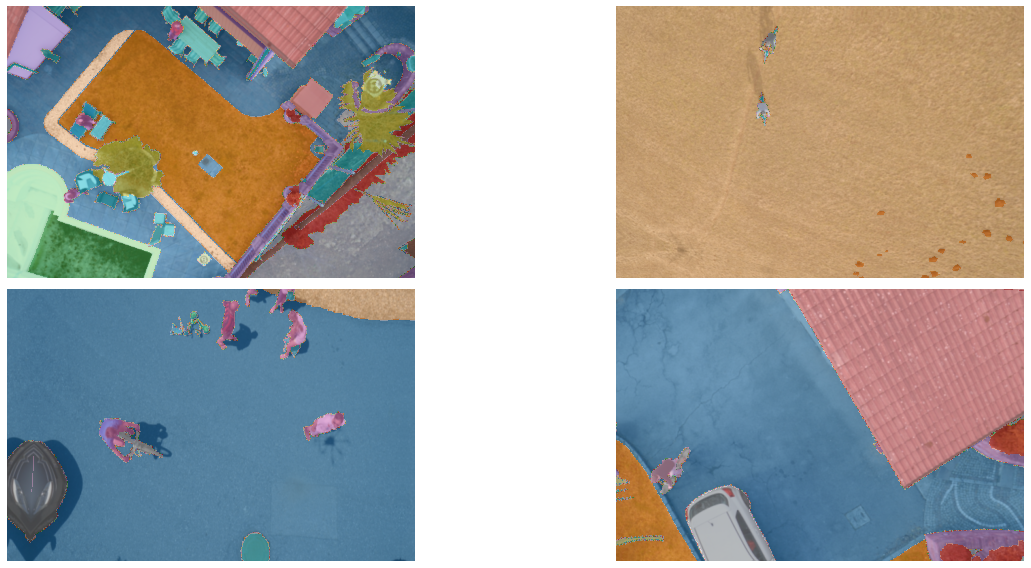

In [31]:
data.show_batch(rows=2 , figsize = (20,8));

In [34]:
len(data.train_ds),len(data.valid_ds),data.c

(360, 40, 26)

In [35]:
data.train_ds[0], data.valid_ds[0]

((Image (3, 200, 300), ImageSegment (1, 200, 300)),
 (Image (3, 200, 300), ImageSegment (1, 200, 300)))

# Model

* Metrics for  mask

In [88]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = -1

def accuracy_mask(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [89]:
metrics = accuracy_mask
wd = 1e-2    # wd = weight decay
arch = models.resnet34
learn = unet_learner(data, arch , wd = wd , metrics = metrics,bottle=True, model_dir = '/content/' )
print(learn.loss_func)

FlattenedLoss of CrossEntropyLoss()


## Finding a suitable learning rate for our model

* With help fast.ai **learning rate finder** function

epoch,train_loss,valid_loss,accuracy_mask,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


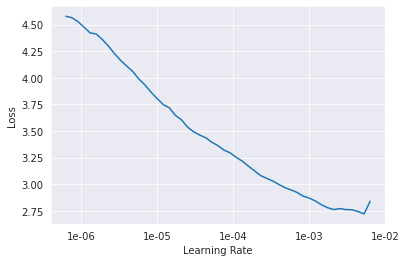

In [91]:
learn.lr_find()
learn.recorder.plot()

In [92]:
gc.collect() # to clear the cache

6107

In [93]:
callbacks = SaveModelCallback(learn, monitor = 'accuracy_mask', every = 'improvement', name = 'best_model' )

In [42]:
learn.fit_one_cycle(10, slice(1e-3), pct_start=0.8,callbacks=[callbacks] )

epoch,train_loss,valid_loss,accuracy_mask,time
0,2.082183,2.004159,0.459658,00:50
1,1.583215,1.554338,0.563896,00:38
2,1.434553,1.492756,0.551205,00:38
3,1.281660,1.295342,0.625743,00:38
4,1.200982,1.288658,0.631432,00:38
5,1.269278,1.406653,0.578773,00:38
6,1.173122,1.174637,0.668354,00:38
7,1.127066,1.448908,0.618899,00:38
8,0.989838,1.010688,0.710308,00:38
9,0.862927,0.997368,0.717389,00:38


Better model found at epoch 0 with accuracy_mask value: 0.4596575200557709.
Better model found at epoch 1 with accuracy_mask value: 0.5638962984085083.
Better model found at epoch 3 with accuracy_mask value: 0.6257429122924805.
Better model found at epoch 4 with accuracy_mask value: 0.631432056427002.
Better model found at epoch 6 with accuracy_mask value: 0.6683541536331177.
Better model found at epoch 8 with accuracy_mask value: 0.7103078961372375.
Better model found at epoch 9 with accuracy_mask value: 0.7173891663551331.


In [44]:
gc.collect()

11282

## To check results of our trained model

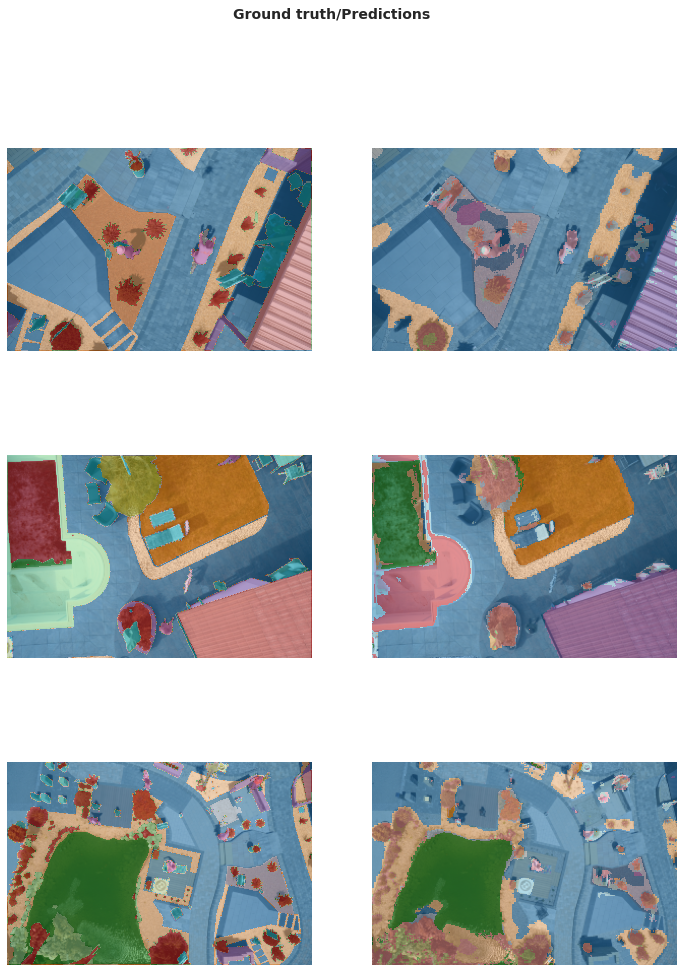

In [43]:
learn.show_results(rows=3, figsize=(12,16))

In [45]:
learn.save('stage-1-big')  # saving the model 
learn.load('stage-1-big');  # loading the model
learn.unfreeze()

## Export the model

In [ ]:
learn.export('/kaggle/working/chest_mask.pkl')

### Load the model  and predict

* Function to make a prediction and Overlap the Drone Images with Predicted drone Mask

In [82]:
def drone_predict(f):
    pred=learn.predict(open_image(f))[0]
    im = Image.open(f)
    pred.show(figsize=(12,6),alpha=0.7,title='Drone with predicted mask')
    plt.imshow(np.asarray(im.resize((300, 200))),alpha=0.4)

### Prediction

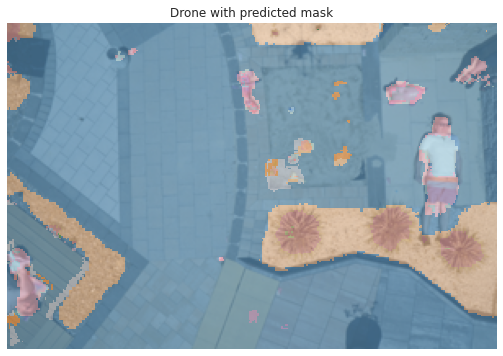

In [83]:
drone_predict(fnames[96])